In [1]:
import os
import json
import jieba
import jieba.analyse
import numpy as np
import pandas as pd
from datetime import datetime

import csv
import uuid
from collections import Counter

import matplotlib.pyplot as plt

## 六、新闻评论及相关分析

### 6.1、数据预处理

#### 6.1.1、读取样本并格式化

In [2]:
comments_data = []
# CSDC新闻评论数据文件路径
comments_date_dir= './news/comment'
i = 1
# 把源格式comment下的所有字段提取到上层。
for path in os.listdir(comments_date_dir):
    comment_date_path = os.path.join(comments_date_dir, path)
    with open(comment_date_path, 'r', encoding='utf-8') as comment_file:
        datas = json.load(comment_file)
        for data in datas:
            for c in data['comment']:  
                cmt = {}
                cmt['hour'] = int(c['time'].split()[1].split(':')[0])
                t= data['time'].split()[0].split('-')
                cmt['time'] = datetime(2020, int(t[0]),int(t[1]))
                cmt['title'] = data['title']
                cmt['url'] = data['url']
                cmt['area'] = c['area']
                cmt['content'] = c['content']
                cmt['nickname'] = c['nickname']
                cmt['reply_to'] = c['reply_to']
                comment_time = datetime.strptime(c['time'], '%Y-%m-%d %H:%M:%S')
                cmt['comment_time'] = comment_time
                cmt['comment_hour'] = comment_time.hour
                # del data['comment']
                comments_data.append(cmt)
print('读取评论共{}条'.format(len(comments_data)))

读取评论共1534616条


In [3]:
comments_data[0]

{'hour': 15,
 'time': datetime.datetime(2020, 3, 5, 0, 0),
 'title': '最高层再度发声释放9信号：5G再成重点 9行业迎风口',
 'url': 'https://finance.sina.com.cn/stock/hyyj/2020-03-05/doc-iimxxstf6457637.shtml',
 'area': '浙江杭州',
 'content': '先让5G在电视台和电视传输上实现，让民众看电视用上5G。使用才是真道理。',
 'nickname': 'zhiyuan195826',
 'reply_to': '',
 'comment_time': datetime.datetime(2020, 3, 5, 15, 13, 21),
 'comment_hour': 15}

#### 6.1.2、转化DataFrame对象，补充缺失值

把上一小节中格式化的数据，转换为DataFrame对象，方便数据的处理。为防止字段null 或nan影响后继计算，做空数据进行填充。

In [4]:
# 把上一小节中格式化的数据，转换为DataFrame对象，方便数据的处理
comments_data = pd.DataFrame(comments_data)
comments_data = comments_data.fillna('')
comments_data.head()

,hour,time,title,url,area,content,nickname,reply_to,comment_time,comment_hour
0,15,2020-03-05,最高层再度发声释放9信号：5G再成重点 9行业迎风口,https://finance.sina.com.cn/stock/hyyj/2020-03...,浙江杭州,先让5G在电视台和电视传输上实现，让民众看电视用上5G。使用才是真道理。,zhiyuan195826,,2020-03-05 15:13:21,15
1,13,2020-03-05,最高层再度发声释放9信号：5G再成重点 9行业迎风口,https://finance.sina.com.cn/stock/hyyj/2020-03...,河北石家庄,5G真正受益的是做服务器的~~,真游戏玩家,,2020-03-05 13:35:03,13
2,12,2020-03-05,最高层再度发声释放9信号：5G再成重点 9行业迎风口,https://finance.sina.com.cn/stock/hyyj/2020-03...,上海,大家应该记得听新闻联播买股票 讲什么就涨什么,JohnFord,,2020-03-05 12:35:39,12
3,12,2020-03-05,最高层再度发声释放9信号：5G再成重点 9行业迎风口,https://finance.sina.com.cn/stock/hyyj/2020-03...,上海,6G 7G都要提上去 5G肯定要加速冲刺了 头筹不能落入他人之手 应用太广泛了 重点关注,JohnFord,,2020-03-05 12:33:43,12
4,12,2020-03-05,最高层再度发声释放9信号：5G再成重点 9行业迎风口,https://finance.sina.com.cn/stock/hyyj/2020-03...,上海,口罩不错 难道谁还能保证后面不出冠3冠4冠5，即使我们不需要 老外也要的 他们产能差,JohnFord,,2020-03-05 12:30:46,12


#### 6.1.3、过滤空内容和去重

经观测，评论内容或URL为空的样本共2条。需去除。并按URL去重。最终有1529663个样本。

In [5]:
comments_data = comments_data.query("content != '' and url != ''")
len(comments_data)

1534614

In [6]:
comments_data = comments_data.drop_duplicates(subset=['url', 'area', 'nickname', 'content', 'comment_time'])
len(comments_data)

1529663

#### 6.1.4、数据观测

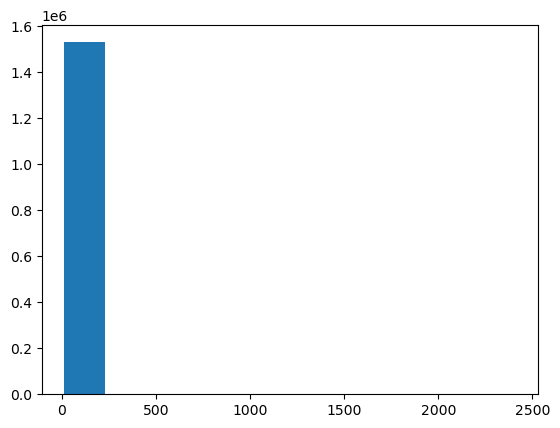

In [7]:
# 评论长度
comment_len = comments_data['content'].map(lambda x: len(x))
plt.hist(comment_len, bins=10, rwidth=0.9)
plt.show()

In [179]:
# 对评论内容的字数长度进行统计，发现存在一部分离散值
comments_data['content'].apply(lambda x: len(x)).describe(percentiles=[.10, .25, .75, .90] )

count    1.529663e+06
mean     2.238149e+01
std      2.820852e+01
min      1.000000e+00
10%      4.000000e+00
25%      7.000000e+00
50%      1.400000e+01
75%      2.700000e+01
90%      4.800000e+01
max      2.421000e+03
Name: content, dtype: float64

#### 6.1.5、构造ID列辅助情感预测

In [9]:
comments_data['id'] = [uuid.uuid4() for _ in range(len(comments_data))]
comments_data['label'] = 0
comments_data[['id', 'time', 'hour', 'area', 'title', 'url', 'label']].head()

,id,time,hour,area,title,url,label
0,c9c5cd51-0987-458f-88c7-39203c6c5df3,2020-03-05,15,浙江杭州,最高层再度发声释放9信号：5G再成重点 9行业迎风口,https://finance.sina.com.cn/stock/hyyj/2020-03...,0
1,2e7391b2-82b5-4a60-b01f-144546462b1b,2020-03-05,13,河北石家庄,最高层再度发声释放9信号：5G再成重点 9行业迎风口,https://finance.sina.com.cn/stock/hyyj/2020-03...,0
2,266ac682-55a0-4043-ba08-efb91a67139f,2020-03-05,12,上海,最高层再度发声释放9信号：5G再成重点 9行业迎风口,https://finance.sina.com.cn/stock/hyyj/2020-03...,0
3,406a0dc1-0128-4df9-bec2-eb80a85f5c07,2020-03-05,12,上海,最高层再度发声释放9信号：5G再成重点 9行业迎风口,https://finance.sina.com.cn/stock/hyyj/2020-03...,0
4,8179b5fb-ce04-4804-ad6e-fb4f696e6cfd,2020-03-05,12,上海,最高层再度发声释放9信号：5G再成重点 9行业迎风口,https://finance.sina.com.cn/stock/hyyj/2020-03...,0


In [10]:
# 因为数据太多，每天随机取2000条出来预测
comments_data_mini = comments_data.groupby('time').apply(lambda t: t.sample(2000, replace=True)).reset_index(drop=True)
comments_data_mini

,hour,time,title,url,area,content,nickname,reply_to,comment_time,comment_hour,id,label
0,22,2020-01-01,使馆遇袭美向中东增兵 特朗普认准伊朗放出狠话,https://news.sina.com.cn/w/2020-01-01/doc-iihn...,北京,你炸伊拉克的后果，赖伊朗干嘛？,实话跟评,,2020-01-01 22:06:03,22,6a9c7e80-6bc3-4cde-ab23-af9c0f3ea2ee,0
1,9,2020-01-01,新华社刊发宣言署名文章：决胜脱贫在今朝,https://news.sina.com.cn/c/2020-01-01/doc-iihn...,张掖汽车南站,决胜脱贫攻坚战。,向阳诗诗,,2020-01-03 09:50:40,9,e552cf1c-711e-4ccf-94ab-f6c2a9d50e95,0
2,10,2020-01-01,2020年起这些新规正式施行 “医”食住行都涵盖,https://news.sina.com.cn/c/2020-01-01/doc-iihn...,广东佛山,做好这些国家要有足够的投入,love幸福别来无恙ebjFiona,,2020-01-01 10:11:57,10,f42e3fa1-1820-4f56-aa61-729c93e5b813,0
3,8,2020-01-01,2020第一天 港警打击暴徒用了这样的高科技,https://news.sina.com.cn/c/2020-01-02/doc-iihn...,广东肇庆,远离暴力,就叫韩老大_447,,2020-01-02 08:28:29,8,d4033148-5164-43b3-b8ff-a6332e0c0da6,0
4,12,2020-01-01,山东舰南海“对峙”美国航母？中美双方尚未发声,https://news.sina.com.cn/c/2020-01-01/doc-iihn...,北京,作恶太多，迟早要还,不系之舟-,,2020-01-02 12:22:28,12,86cd8063-7c08-47e1-b3b8-6ce7ecccb09e,0
...,...,...,...,...,...,...,...,...,...,...,...,...
137995,0,2020-03-09,【原油】OPEC+会议“谈崩” 油价将加速探底,https://finance.sina.com.cn/money/future/roll/...,浙江金华,对中国来说，这是一个极好的机会，如果在期货市场三十以下买入5000亿吨的战略投资，那是相当赚...,用户7127307508,,2020-03-10 00:49:08,0,46120106-3896-44c9-86e6-484df920ef5a,0
137996,7,2020-03-09,【原油】OPEC+会议“谈崩” 油价将加速探底,https://finance.sina.com.cn/money/future/roll/...,江西鹰潭,不知要有多少人跳楼,江西赣电52,,2020-03-09 07:08:18,7,fbbf5ef4-6a68-4a17-9d11-fc43f32767b6,0
137997,7,2020-03-09,【原油】OPEC+会议“谈崩” 油价将加速探底,https://finance.sina.com.cn/money/future/roll/...,江西鹰潭,不知要有多少人跳楼,江西赣电52,,2020-03-09 07:08:18,7,fbbf5ef4-6a68-4a17-9d11-fc43f32767b6,0
137998,7,2020-03-09,【原油】OPEC+会议“谈崩” 油价将加速探底,https://finance.sina.com.cn/money/future/roll/...,江西鹰潭,不知要有多少人跳楼,江西赣电52,,2020-03-09 07:08:18,7,fbbf5ef4-6a68-4a17-9d11-fc43f32767b6,0


In [11]:
# 保存ID化的数据集，后面要与评论的数据做联合统计和对比
comments_data_mini.to_csv(
        './news/output/comments_mini.csv',
        index=False, 
        quoting = csv.QUOTE_ALL,
        quotechar='"',
        escapechar=',',
        encoding = 'utf-8')
comments_emotion = comments_data_mini[['id', 'title', 'content', 'label']]
# comments_emotion['title']=' '
comments_emotion.to_csv(
        './news/output/comments_emotion_test.csv',
        index=False, 
        quoting = csv.QUOTE_ALL,
        quotechar='"',
        escapechar=',',
        encoding = 'utf-8')
len(comments_data_mini),len(comments_emotion)

(138000, 138000)

### 6.2、情感分析模型

**`注：本章节详细内容，见《CCF_BDCI_2019/run_bert.ipynb》 文件。`**

#### 6.2.1、引入CCF_BDCI_2019互联网新闻情感分析并训练模型

#### 6.2.2、CSDC-News数据集新闻内容情感预测

#### 6.2.2、CSDC-News数据集新闻评论情感预测

In [13]:
comments_data_mini = pd.read_csv('./news/output/comments_mini.csv')
comments_data_mini['hour'] = comments_data_mini['comment_time'].map(lambda t: t.split()[1].split(':')[0])
comments_data_mini['id'].head()

0    6a9c7e80-6bc3-4cde-ab23-af9c0f3ea2ee
1    e552cf1c-711e-4ccf-94ab-f6c2a9d50e95
2    f42e3fa1-1820-4f56-aa61-729c93e5b813
3    d4033148-5164-43b3-b8ff-a6332e0c0da6
4    86cd8063-7c08-47e1-b3b8-6ce7ecccb09e
Name: id, dtype: object

In [39]:
comments_emotion = pd.read_csv('./CCF_BDCI_2019/output/chinese-roberta-wwm-ext-large/predicted_comments.csv',encoding = 'utf-8')
comments_emotion['label_0'] = comments_emotion['label_0'].map(lambda a: 1 if a>=0.5 else 0)
comments_emotion['label_1'] = comments_emotion['label_1'].map(lambda a: 1 if a>=0.5 else 0)
comments_emotion['label_2'] = comments_emotion['label_2'].map(lambda a: 1 if a>=0.5 else 0)
comments_emotion.head()

,id,label_0,label_1,label_2
0,1c9160ec-1300-4929-9035-cc16c0a1a90a,0,1,0
1,7b4266fd-b345-438e-b4dc-2c5cda55df1b,0,1,0
2,224209ad-63f1-4daa-b7ee-0ca50f3ba923,0,1,0
3,14a6173f-7218-4abe-b1f1-bc47e427a6d6,0,1,0
4,9b0154f9-b6ac-47ed-8fa7-d5b6e6669618,0,1,0


In [40]:
len(comments_emotion), len(comments_data_mini)

(138000, 138000)

In [63]:
comments_emotion_fin = pd.concat([comments_data_mini[['url', 'time', 'hour']],comments_emotion] , axis=1)
comments_emotion_fin.head()

,url,time,hour,id,label_0,label_1,label_2
0,https://tech.sina.com.cn/5g/i/2020-01-01/doc-i...,2020-01-01,00,1c9160ec-1300-4929-9035-cc16c0a1a90a,0,1,0
1,https://mil.news.sina.com.cn/jssd/2020-01-01/d...,2020-01-01,06,7b4266fd-b345-438e-b4dc-2c5cda55df1b,0,1,0
2,https://finance.sina.com.cn/stock/usstock/c/20...,2020-01-01,00,224209ad-63f1-4daa-b7ee-0ca50f3ba923,0,1,0
3,https://news.sina.com.cn/w/2020-01-01/doc-iihn...,2020-01-01,10,14a6173f-7218-4abe-b1f1-bc47e427a6d6,0,1,0
4,https://finance.sina.com.cn/money/bank/2020-01...,2020-01-01,16,9b0154f9-b6ac-47ed-8fa7-d5b6e6669618,0,1,0


In [60]:
len(comments_emotion_fin)

138000

### 6.3、统计分析

#### 6.3.1、新闻评论数量按日统计走趋图

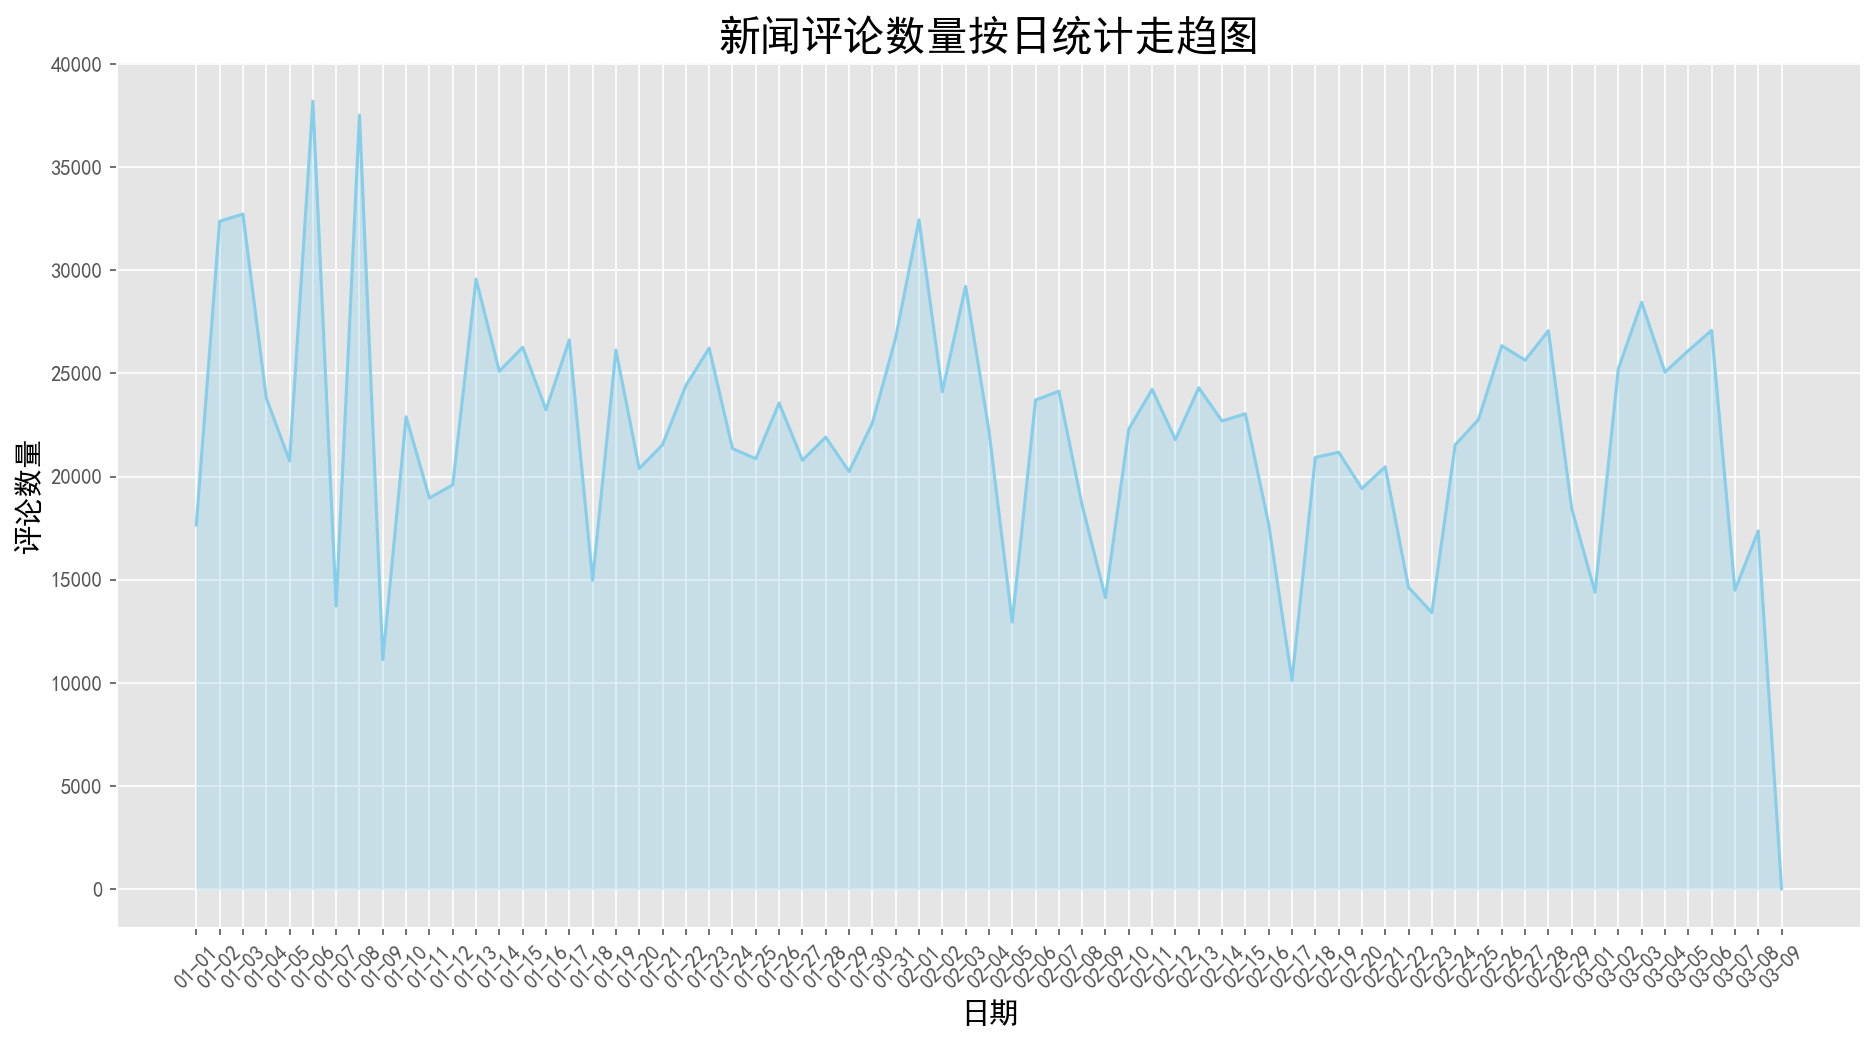

In [125]:
comments_day = comments_data.groupby('time')['id'].count().reset_index()

x=range(len(comments_day))
y=comments_day['id'].values
x_tick_label = comments_day['time'].map(lambda t: t.strftime('%m-%d')).values
plt.figure(figsize=(15, 7.5), dpi=150)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.style.use("ggplot")
plt.fill_between(x, y, color="skyblue", alpha=0.3)
plt.plot(x, y, color="skyblue")
plt.title("新闻评论数量按日统计走趋图", loc="center",size=20)
plt.xlabel("日期", size=14)
plt.xticks(x,labels = x_tick_label, rotation = 45)
plt.ylabel("评论数量", size=14)
plt.show()

#### 6.3.2、新闻评论数量的地域分布

In [100]:
comments_area = comments_data.groupby('area')['id'].count().reset_index()
comments_area['area']

0                      
1                 169医院
2       17.5錫都時代今典國際影視城
3                1912广场
4                  1号聚点
             ...       
5561                龙虎庄
5562              龙辉工业园
5563             龙锦苑东五区
5564                龚家楼
5565                龟山寺
Name: area, Length: 5566, dtype: object

In [67]:

# 统计包含全国34个省、直辖市、自治区名称的地域数据
province_name = ['北京', '天津', '上海', '重庆', '河北', '河南', '云南', '辽宁', '黑龙江', '湖南', '安徽', '山东', '新疆',
                 '江苏', '浙江', '江西', '湖北', '广西', '甘肃', '山西', '内蒙古', '陕西', '吉林', '福建', '贵州', '广东',
                 '青海', '西藏', '四川', '宁夏', '海南', '台湾', '香港', '澳门']
# 用省名查找
def is_in_province_name(area):
    for p in province_name:
        if p in area:
            return True
    return False
# 按省统计
def get_area(area):
    for p in province_name:
        if p in area:
            return p
    return ''

In [15]:
comments_area = comments_data.copy()
comments_area = comments_area[comments_area['area'].map(is_in_province_name)]
comments_area['area'] = comments_area['area'].map(get_area)

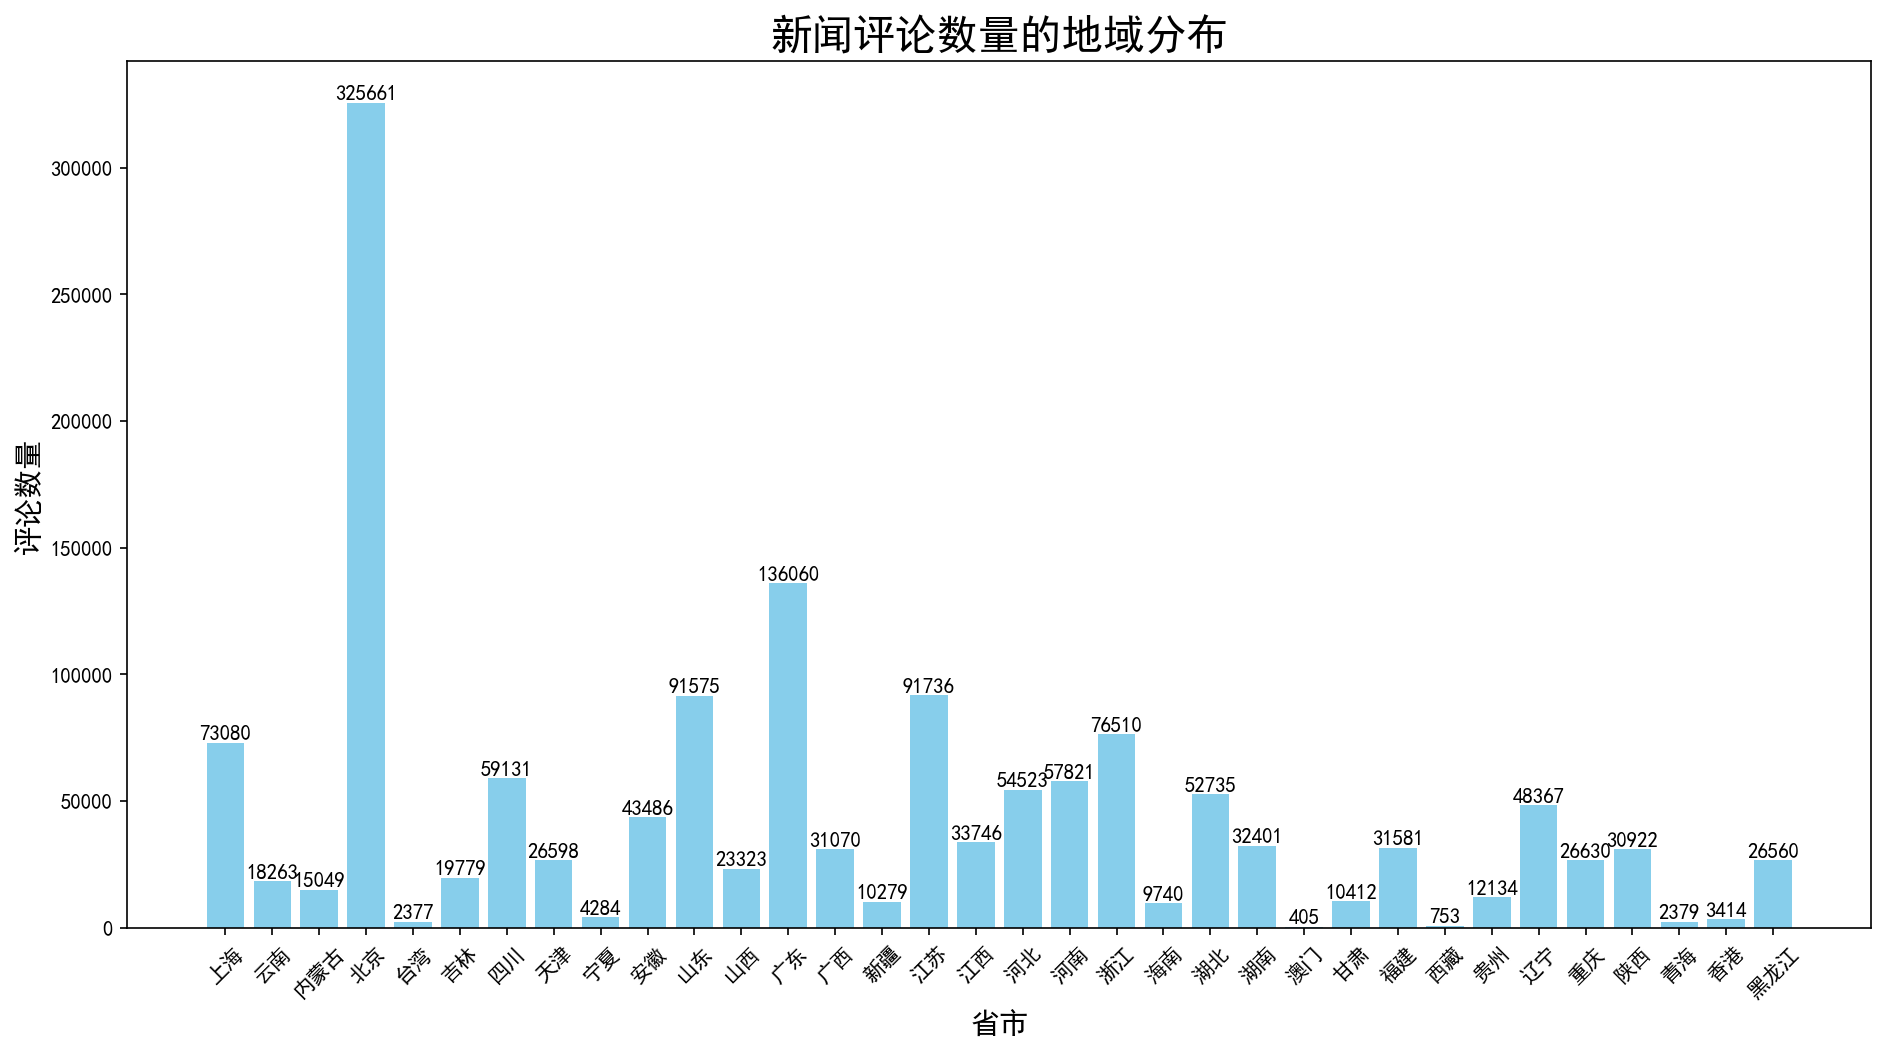

In [16]:
comments_area =comments_area.groupby('area')['id'].count().reset_index()

x=range(len(comments_area))
y=comments_area['id'].values
x_tick_label = comments_area['area'].values
plt.figure(figsize=(15, 7.5), dpi=150)
plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.bar(x, y, color="skyblue")
bar = plt.bar(x, y, width= 0.8, color="skyblue") 
plt.bar_label(bar, label_type='edge') 
plt.title("新闻评论数量的地域分布", loc="center",size=20)
plt.xlabel("省市", size=14)
plt.xticks(x,labels = x_tick_label, rotation = 45)
plt.ylabel("评论数量", size=14)
plt.show()

#### 6.3.3、新闻评论数量的时段分布

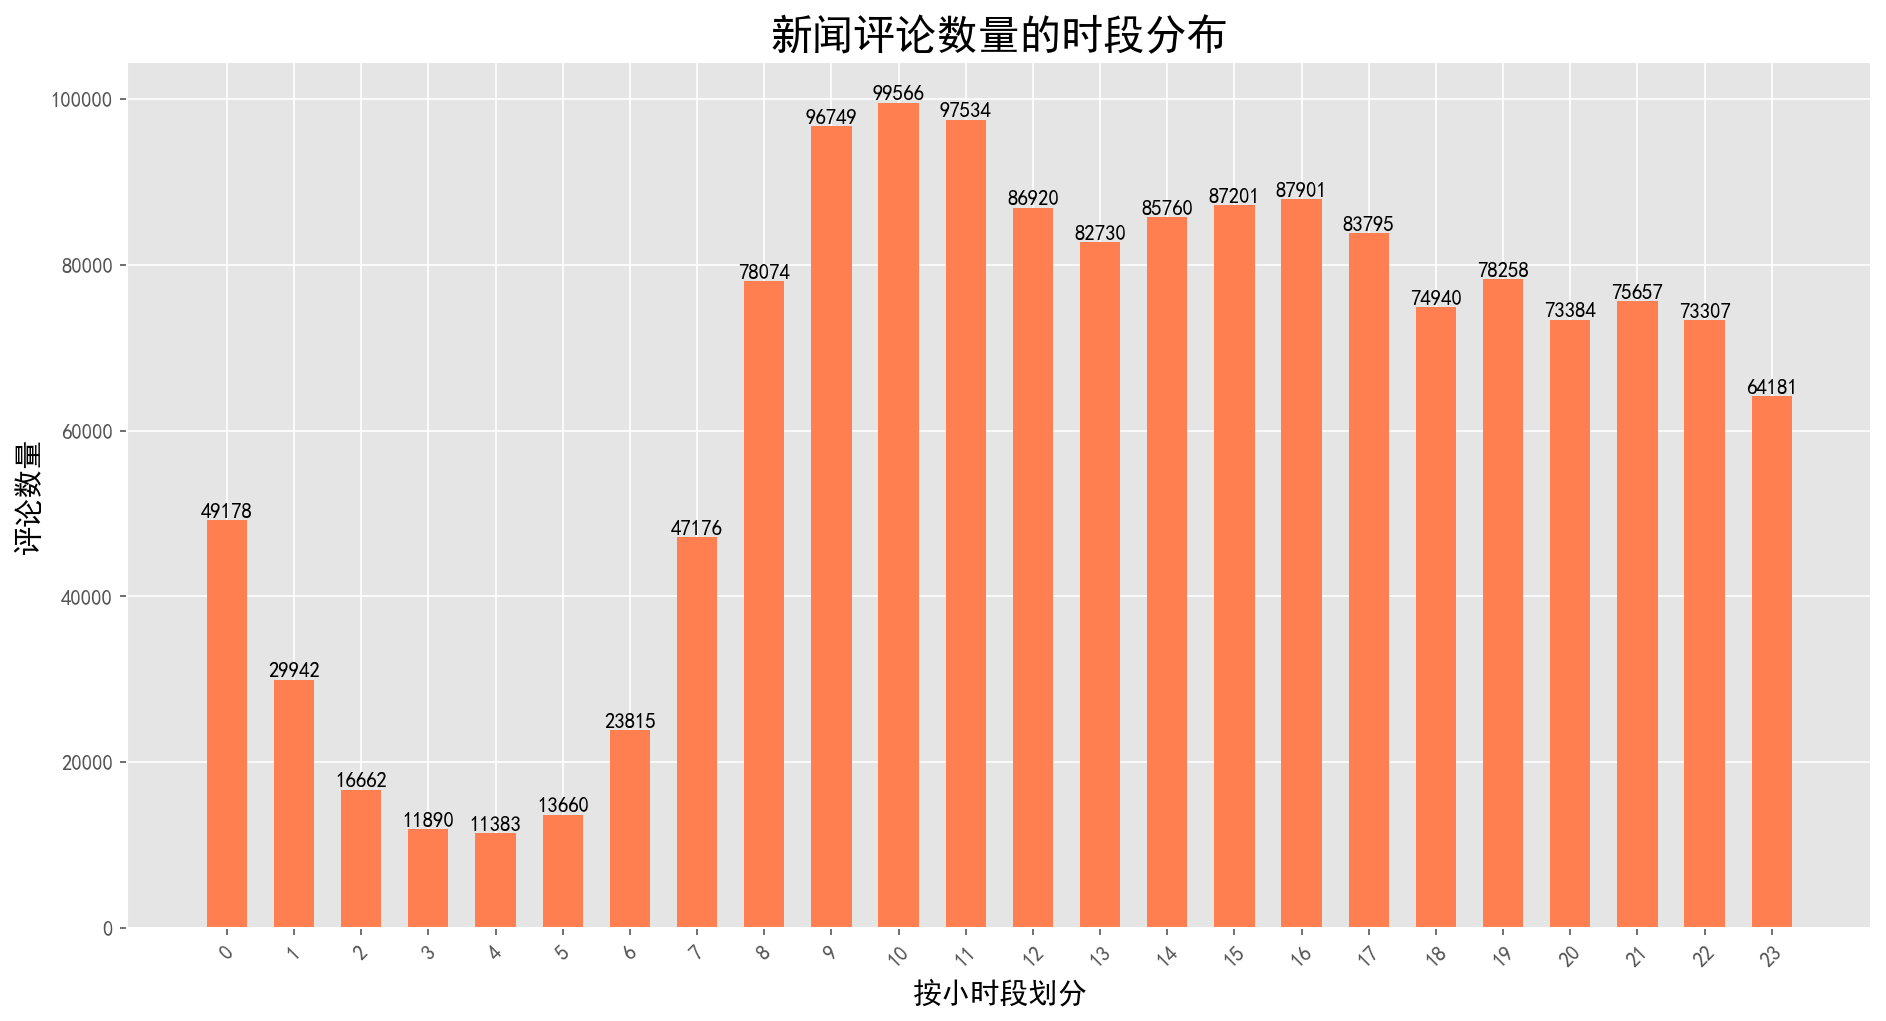

In [127]:
comments_hour = comments_data.groupby('hour')['id'].count().reset_index()

x=range(len(comments_hour))
y=comments_hour['id'].values
x_tick_label = comments_hour['hour'].values
plt.figure(figsize=(15, 7.5), dpi=150)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.style.use("ggplot")
bar = plt.bar(x, y, width= 0.6, color="coral") 
plt.bar_label(bar, label_type='edge') 
plt.title("新闻评论数量的时段分布", loc="center",size=20)
plt.xlabel("按小时段划分", size=14)
plt.xticks(x,labels = x_tick_label, rotation = 45)
plt.ylabel("评论数量", size=14)
plt.show()

#### 6.3.4、新闻评论情感按日统计走趋图

In [38]:
comments_data_mini = pd.read_csv('./news/output/comments_mini.csv')
comments_data_mini['hour'] = comments_data_mini['comment_time'].map(lambda t: t.split()[1].split(':')[0])
comments_data_mini['id'].head()

0    6a9c7e80-6bc3-4cde-ab23-af9c0f3ea2ee
1    e552cf1c-711e-4ccf-94ab-f6c2a9d50e95
2    f42e3fa1-1820-4f56-aa61-729c93e5b813
3    d4033148-5164-43b3-b8ff-a6332e0c0da6
4    86cd8063-7c08-47e1-b3b8-6ce7ecccb09e
Name: id, dtype: object

In [40]:
comments_emotion = pd.read_csv('./CCF_BDCI_2019/output/chinese-roberta-wwm-ext-large/predicted_comments.csv',encoding = 'utf-8')
comments_emotion['label_0'] = comments_emotion['label_0'].map(lambda a: 1 if a>=0.5 else 0)
comments_emotion['label_1'] = comments_emotion['label_1'].map(lambda a: 1 if a>=0.5 else 0)
comments_emotion['label_2'] = comments_emotion['label_2'].map(lambda a: 1 if a>=0.5 else 0)
comments_emotion.head()

,id,label_0,label_1,label_2
0,6a9c7e80-6bc3-4cde-ab23-af9c0f3ea2ee,0,0,1
1,e552cf1c-711e-4ccf-94ab-f6c2a9d50e95,0,1,0
2,f42e3fa1-1820-4f56-aa61-729c93e5b813,0,1,0
3,d4033148-5164-43b3-b8ff-a6332e0c0da6,0,0,1
4,86cd8063-7c08-47e1-b3b8-6ce7ecccb09e,0,0,1


In [41]:
len(comments_emotion), len(comments_data_mini)

(138000, 138000)

In [49]:
comments_emotion_fin = pd.concat([comments_data_mini[['url', 'area', 'time', 'hour']],comments_emotion] , axis=1)
comments_emotion_fin.head()

,url,area,time,hour,id,label_0,label_1,label_2
0,https://news.sina.com.cn/w/2020-01-01/doc-iihn...,北京,2020-01-01,22,6a9c7e80-6bc3-4cde-ab23-af9c0f3ea2ee,0,0,1
1,https://news.sina.com.cn/c/2020-01-01/doc-iihn...,张掖汽车南站,2020-01-01,09,e552cf1c-711e-4ccf-94ab-f6c2a9d50e95,0,1,0
2,https://news.sina.com.cn/c/2020-01-01/doc-iihn...,广东佛山,2020-01-01,10,f42e3fa1-1820-4f56-aa61-729c93e5b813,0,1,0
3,https://news.sina.com.cn/c/2020-01-02/doc-iihn...,广东肇庆,2020-01-01,08,d4033148-5164-43b3-b8ff-a6332e0c0da6,0,0,1
4,https://news.sina.com.cn/c/2020-01-01/doc-iihn...,北京,2020-01-01,12,86cd8063-7c08-47e1-b3b8-6ce7ecccb09e,0,0,1


In [50]:
comments_emotion_day = comments_emotion_fin.groupby('time')['label_0','label_1','label_2'].sum().reset_index()
comments_emotion_day

/tmp/ipykernel_33484/2146852295.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  comments_emotion_day = comments_emotion_fin.groupby('time')['label_0','label_1','label_2'].sum().reset_index()


,time,label_0,label_1,label_2
0,2020-01-01,13,1131,855
1,2020-01-02,35,1022,941
2,2020-01-03,29,992,970
3,2020-01-04,5,994,997
4,2020-01-05,10,931,1033
...,...,...,...,...
64,2020-03-05,62,1164,771
65,2020-03-06,45,1119,836
66,2020-03-07,24,1119,847
67,2020-03-08,23,1045,931


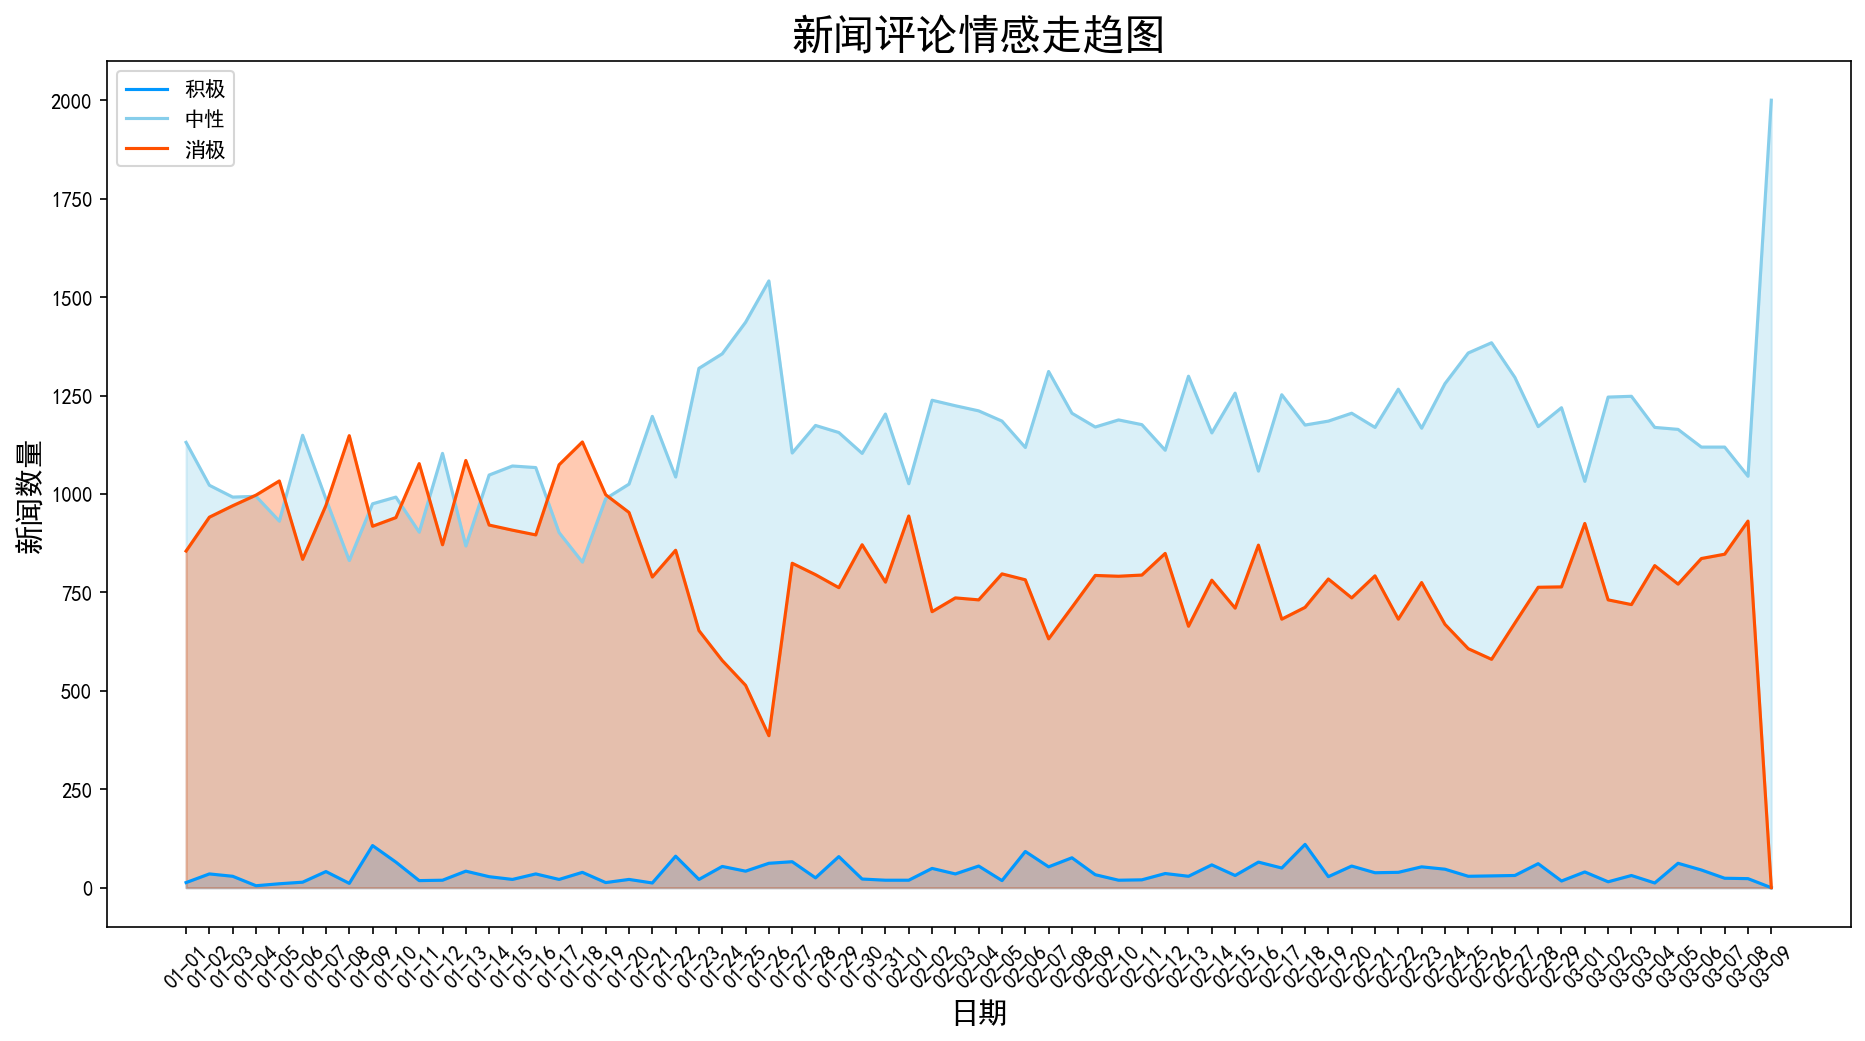

In [52]:
a,b,c = comments_emotion_day['label_0'].values, comments_emotion_day['label_1'].values, comments_emotion_day['label_2'].values
x=range(len(comments_emotion_day))
x_tick_label = comments_emotion_day['time'].map(lambda t: t.replace('2020-','')).values
plt.figure(figsize=(15, 7.5), dpi=150)
plt.rcParams['font.sans-serif'] = ['SimHei']

plt.fill_between(x, a, color="#0198ff", alpha=0.3)
plt.plot(x, a, color="#0198ff", label='积极')
plt.fill_between(x, b, color="skyblue", alpha=0.3)
plt.plot(x, b, color="skyblue", label='中性')
plt.fill_between(x, c, color="#ff5000", alpha=0.3)
plt.plot(x, c, color="#ff5000", label='消极')

plt.title("新闻评论情感走趋图", loc="center",size=20)
plt.xlabel("日期", size=14)
plt.xticks(x,labels = x_tick_label, rotation = 45)
plt.ylabel("新闻数量", size=14)
plt.legend()
plt.show()

#### 6.3.5、新闻评论情感的地域分布

In [58]:
comments_emotion_area = comments_emotion_fin.copy()
comments_emotion_area

,url,area,time,hour,id,label_0,label_1,label_2
0,https://news.sina.com.cn/w/2020-01-01/doc-iihn...,北京,2020-01-01,22,6a9c7e80-6bc3-4cde-ab23-af9c0f3ea2ee,0,0,1
1,https://news.sina.com.cn/c/2020-01-01/doc-iihn...,张掖汽车南站,2020-01-01,09,e552cf1c-711e-4ccf-94ab-f6c2a9d50e95,0,1,0
2,https://news.sina.com.cn/c/2020-01-01/doc-iihn...,广东佛山,2020-01-01,10,f42e3fa1-1820-4f56-aa61-729c93e5b813,0,1,0
3,https://news.sina.com.cn/c/2020-01-02/doc-iihn...,广东肇庆,2020-01-01,08,d4033148-5164-43b3-b8ff-a6332e0c0da6,0,0,1
4,https://news.sina.com.cn/c/2020-01-01/doc-iihn...,北京,2020-01-01,12,86cd8063-7c08-47e1-b3b8-6ce7ecccb09e,0,0,1
...,...,...,...,...,...,...,...,...
137995,https://finance.sina.com.cn/money/future/roll/...,浙江金华,2020-03-09,00,46120106-3896-44c9-86e6-484df920ef5a,0,1,0
137996,https://finance.sina.com.cn/money/future/roll/...,江西鹰潭,2020-03-09,07,fbbf5ef4-6a68-4a17-9d11-fc43f32767b6,0,1,0
137997,https://finance.sina.com.cn/money/future/roll/...,江西鹰潭,2020-03-09,07,fbbf5ef4-6a68-4a17-9d11-fc43f32767b6,0,1,0
137998,https://finance.sina.com.cn/money/future/roll/...,江西鹰潭,2020-03-09,07,fbbf5ef4-6a68-4a17-9d11-fc43f32767b6,0,1,0


In [72]:
comments_emotion_area = comments_emotion_fin.copy()
comments_emotion_area = comments_emotion_area[comments_emotion_area['area'].map(lambda a: is_in_province_name(str(a)))]
comments_emotion_area['area'] = comments_emotion_area['area'].map(lambda a: get_area(str(a)))
comments_emotion_area

,url,area,time,hour,id,label_0,label_1,label_2
0,https://news.sina.com.cn/w/2020-01-01/doc-iihn...,北京,2020-01-01,22,6a9c7e80-6bc3-4cde-ab23-af9c0f3ea2ee,0,0,1
2,https://news.sina.com.cn/c/2020-01-01/doc-iihn...,广东,2020-01-01,10,f42e3fa1-1820-4f56-aa61-729c93e5b813,0,1,0
3,https://news.sina.com.cn/c/2020-01-02/doc-iihn...,广东,2020-01-01,08,d4033148-5164-43b3-b8ff-a6332e0c0da6,0,0,1
4,https://news.sina.com.cn/c/2020-01-01/doc-iihn...,北京,2020-01-01,12,86cd8063-7c08-47e1-b3b8-6ce7ecccb09e,0,0,1
5,https://mil.news.sina.com.cn/china/2020-01-01/...,陕西,2020-01-01,15,63e873be-3001-47aa-9b11-527f0209ee97,0,1,0
...,...,...,...,...,...,...,...,...
137995,https://finance.sina.com.cn/money/future/roll/...,浙江,2020-03-09,00,46120106-3896-44c9-86e6-484df920ef5a,0,1,0
137996,https://finance.sina.com.cn/money/future/roll/...,江西,2020-03-09,07,fbbf5ef4-6a68-4a17-9d11-fc43f32767b6,0,1,0
137997,https://finance.sina.com.cn/money/future/roll/...,江西,2020-03-09,07,fbbf5ef4-6a68-4a17-9d11-fc43f32767b6,0,1,0
137998,https://finance.sina.com.cn/money/future/roll/...,江西,2020-03-09,07,fbbf5ef4-6a68-4a17-9d11-fc43f32767b6,0,1,0


In [73]:
comments_emotion_area =comments_emotion_area.groupby('area')['label_0','label_1','label_2'].sum().reset_index()

/tmp/ipykernel_33484/3089086204.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  comments_emotion_area =comments_emotion_area.groupby('area')['label_0','label_1','label_2'].sum().reset_index()


In [74]:
comments_emotion_area

,area,label_0,label_1,label_2
0,上海,121,3673,2892
1,云南,23,922,665
2,内蒙古,33,743,562
3,北京,472,15976,11483
4,台湾,8,132,62
5,吉林,27,1013,761
6,四川,121,3145,2209
7,天津,43,1322,1039
8,宁夏,5,205,165
9,安徽,68,2282,1547


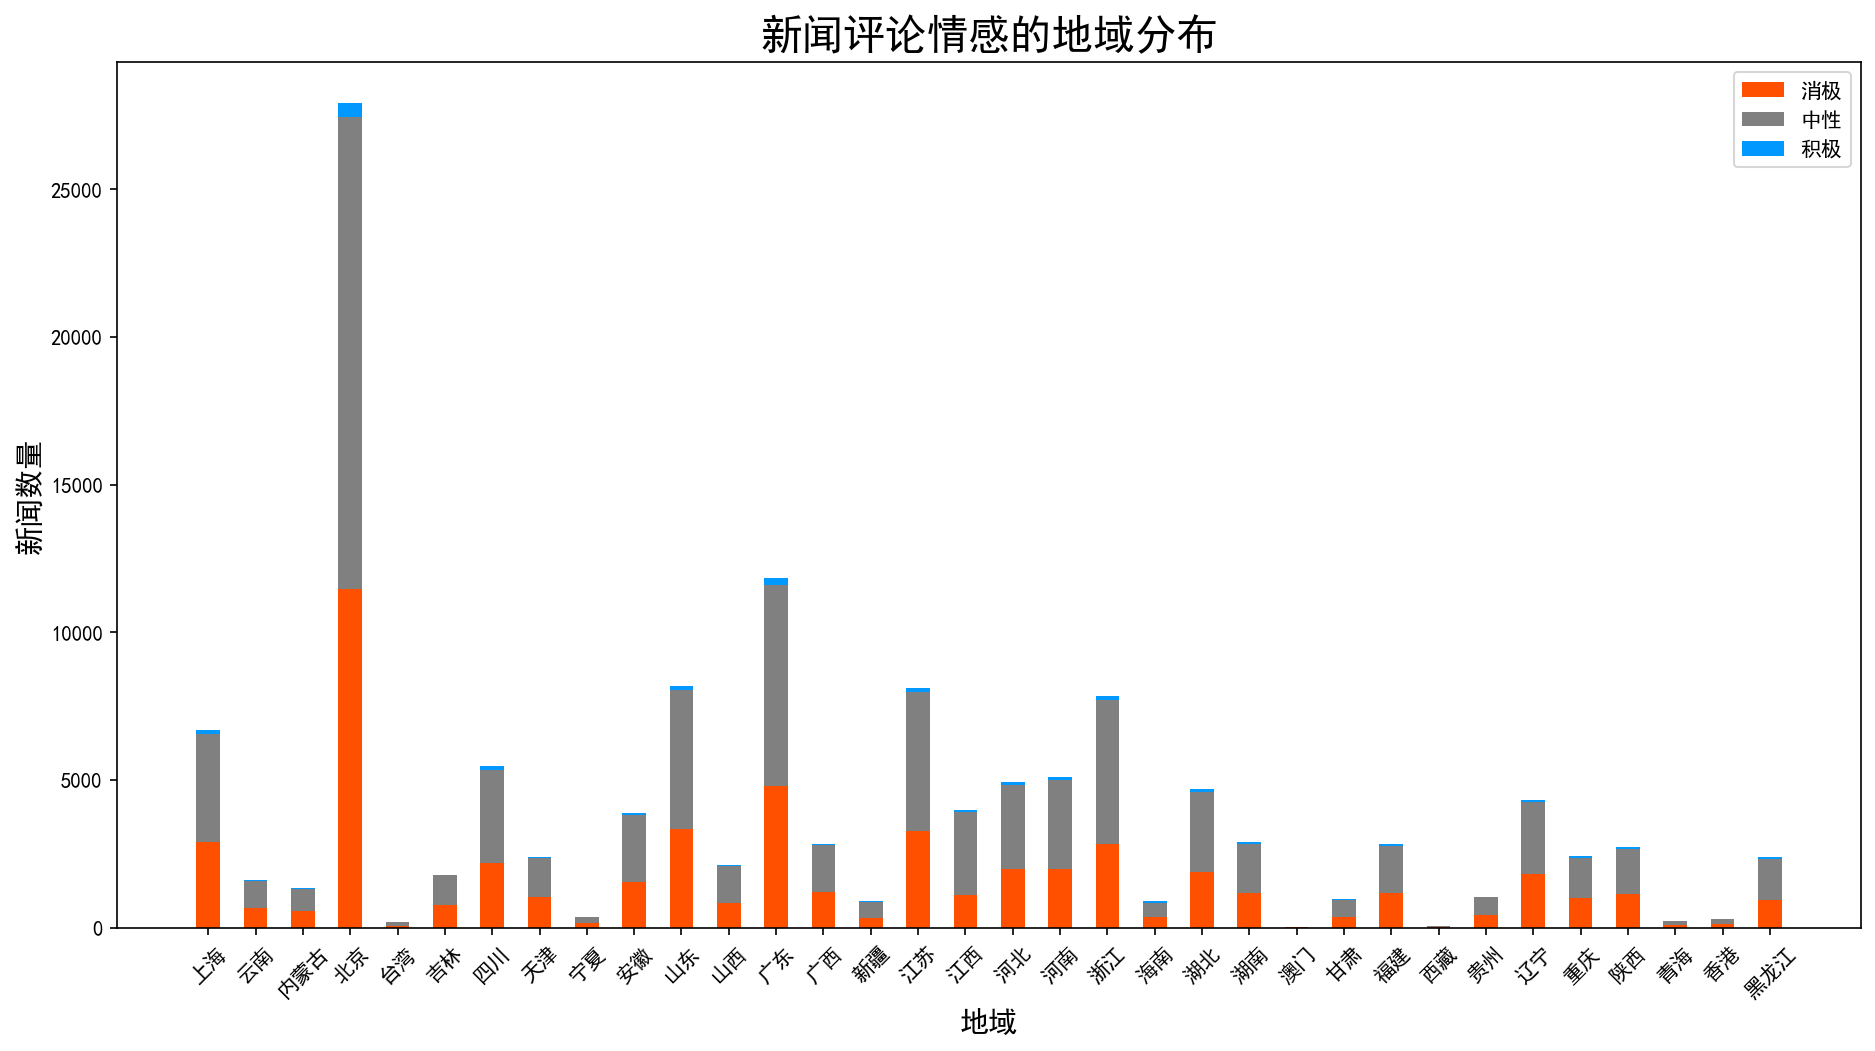

In [81]:
a,b,c = comments_emotion_area['label_2'].values, comments_emotion_area['label_1'].values, comments_emotion_area['label_0'].values
x=range(len(comments_emotion_area))
x_tick_label = comments_emotion_area['area'].map(lambda t: t.replace('2020-','')).values
plt.figure(figsize=(15, 7.5), dpi=150)
plt.rcParams['font.sans-serif'] = ['SimHei']

# plt.fill_between(x, a, color="#0198ff", alpha=0.3)
# plt.plot(x, a, color="#0198ff", label='积极')
# plt.fill_between(x, b, color="skyblue", alpha=0.3)
# plt.plot(x, b, color="skyblue", label='中性')
# plt.fill_between(x, c, color="#ff5000", alpha=0.3)
# plt.plot(x, c, color="#ff5000", label='消极')

plt.bar(x, a, width=0.5, color='#ff5000', label='消极')
plt.bar(x, b, bottom=a, width=0.5, color='gray', label='中性')
plt.bar(x, c, bottom=a+b, width=0.5, color='#0198ff', label='积极')

plt.title("新闻评论情感的地域分布", loc="center",size=20)
plt.xlabel("地域", size=14)
plt.xticks(x,labels = x_tick_label, rotation = 45)
plt.ylabel("新闻数量", size=14)
plt.legend()
plt.show()

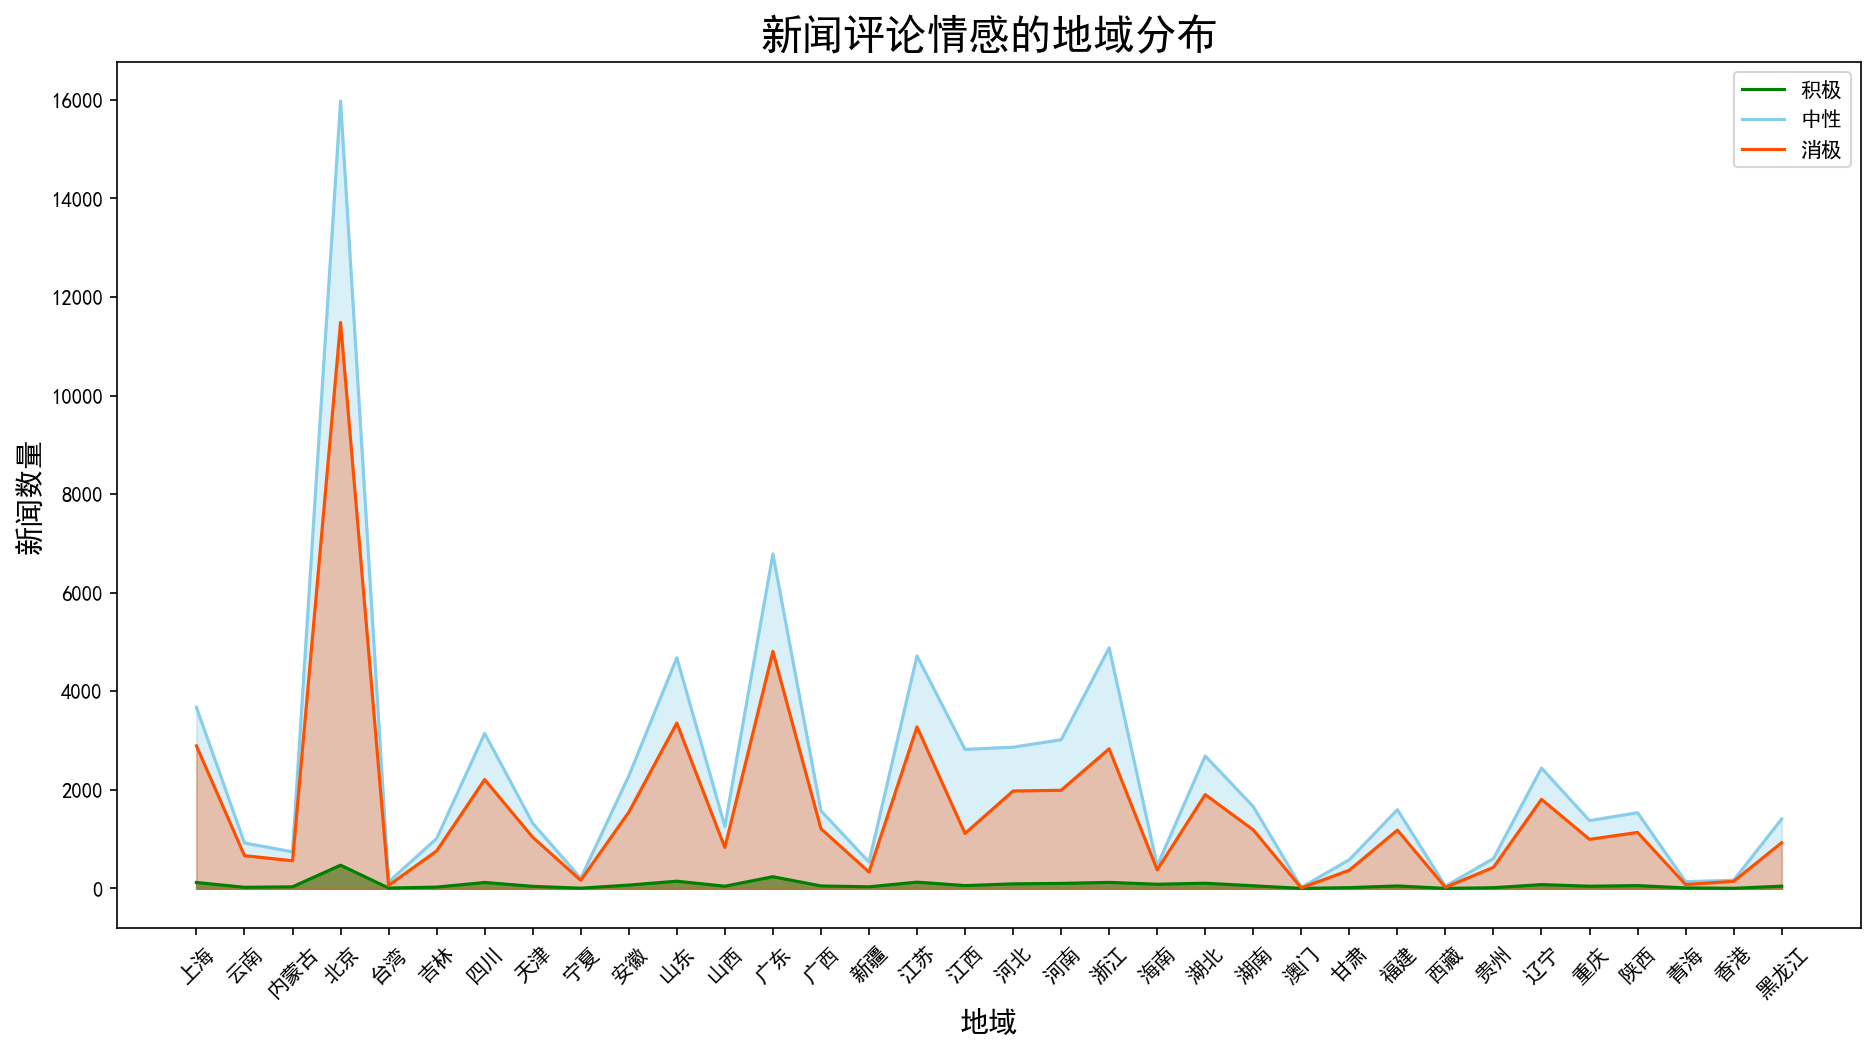

In [80]:
a,b,c = comments_emotion_area['label_0'].values, comments_emotion_area['label_1'].values, comments_emotion_area['label_2'].values
x=range(len(comments_emotion_area))
x_tick_label = comments_emotion_area['area'].map(lambda t: t.replace('2020-','')).values
plt.figure(figsize=(15, 7.5), dpi=150)
plt.rcParams['font.sans-serif'] = ['SimHei']

plt.fill_between(x, a, color="green", alpha=0.8)
plt.plot(x, a, color="green", label='积极')
plt.fill_between(x, b, color="skyblue", alpha=0.3)
plt.plot(x, b, color="skyblue", label='中性')
plt.fill_between(x, c, color="#ff5000", alpha=0.3)
plt.plot(x, c, color="#ff5000", label='消极')


plt.title("新闻评论情感的地域分布", loc="center",size=20)
plt.xlabel("地域", size=14)
plt.xticks(x,labels = x_tick_label, rotation = 45)
plt.ylabel("新闻数量", size=14)
plt.legend()
plt.show()

#### 6.3.6、新闻评论情感的时段分布

In [82]:
comments_emotion_hour = comments_emotion_fin.groupby('hour')['label_0','label_1','label_2'].sum().reset_index()
comments_emotion_hour

/tmp/ipykernel_33484/2278625288.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  comments_emotion_hour = comments_emotion_fin.groupby('hour')['label_0','label_1','label_2'].sum().reset_index()


,hour,label_0,label_1,label_2
0,00,98,3581,1790
1,01,55,1495,1032
2,02,23,868,631
3,03,26,601,412
4,04,31,565,426
5,05,23,721,473
6,06,38,1251,873
7,07,79,3393,1754
8,08,125,3948,2657
9,09,159,4950,3440


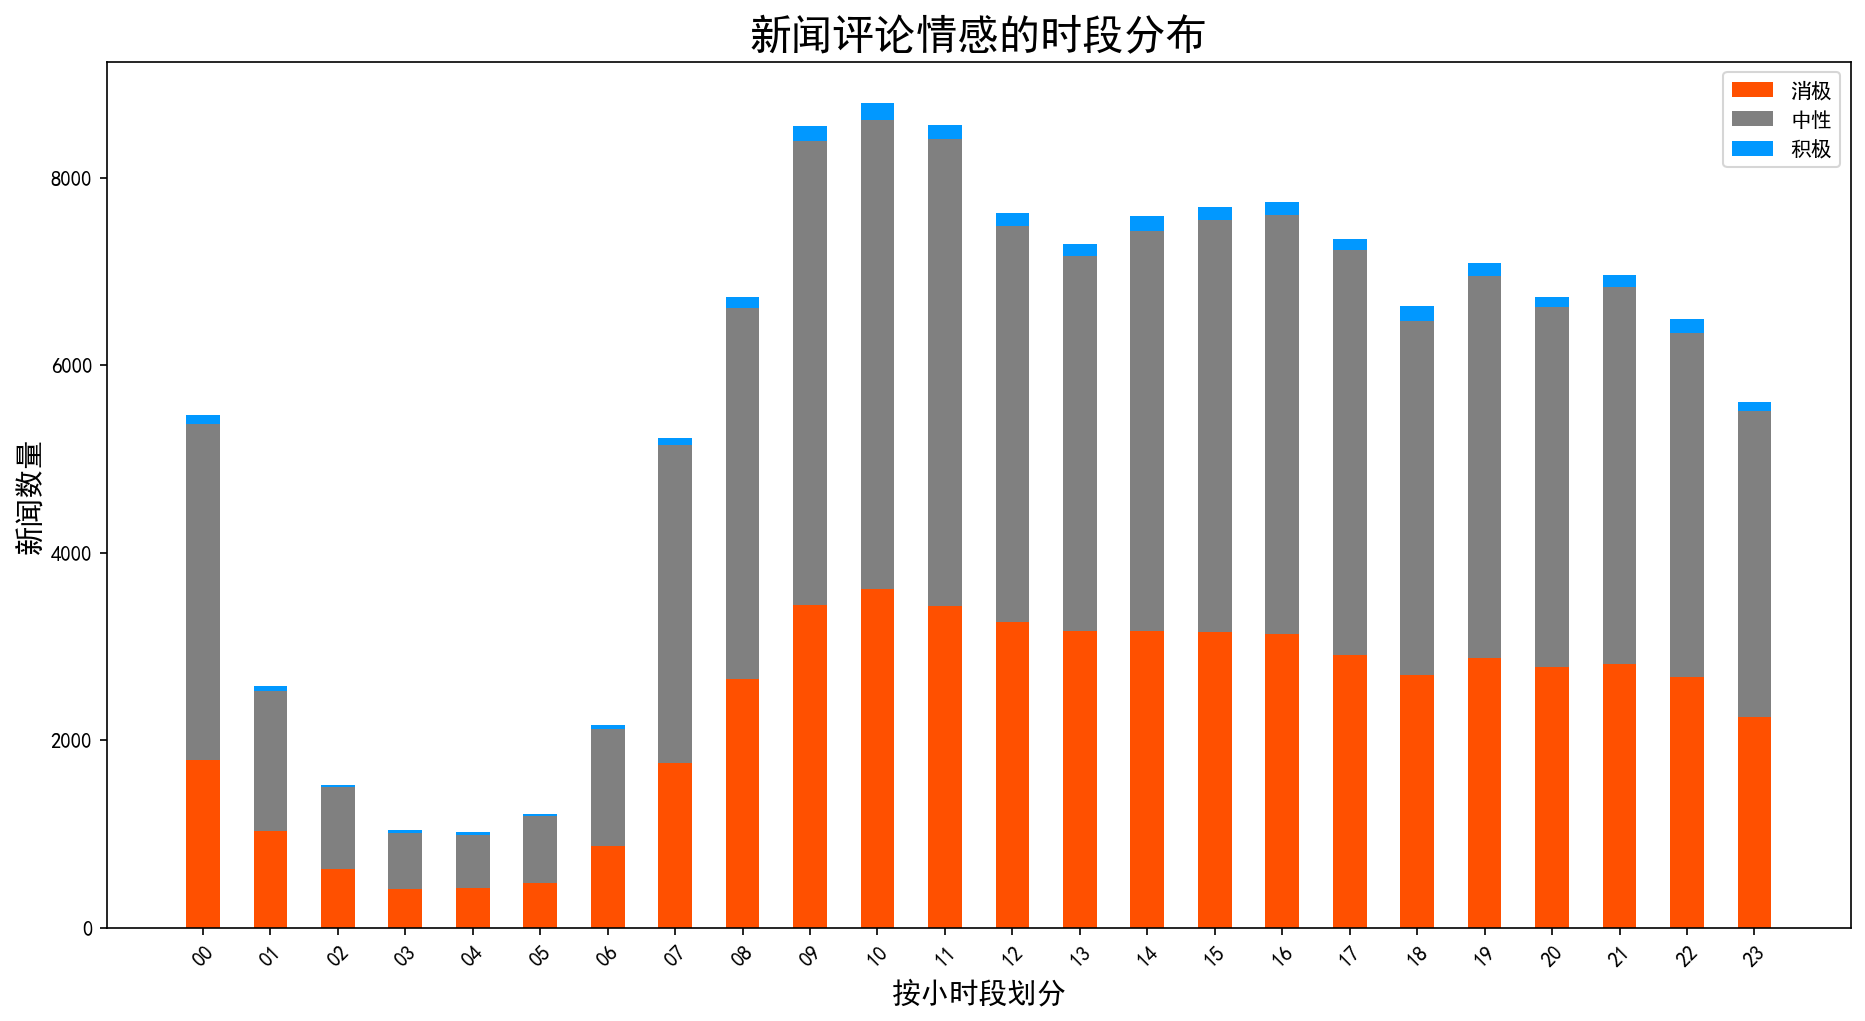

In [83]:
a,b,c = comments_emotion_hour['label_2'].values, comments_emotion_hour['label_1'].values, comments_emotion_hour['label_0'].values
x=range(len(comments_emotion_hour))
x_tick_label = comments_emotion_hour['hour'].values
plt.figure(figsize=(15, 7.5), dpi=150)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.bar(x, a, width=0.5, color='#ff5000', label='消极')
plt.bar(x, b, bottom=a, width=0.5, color='gray', label='中性')
plt.bar(x, c, bottom=a+b, width=0.5, color='#0198ff', label='积极')
plt.title("新闻评论情感的时段分布", loc="center",size=20)
plt.xlabel("按小时段划分", size=14)
plt.xticks(x,labels = x_tick_label, rotation = 45)
plt.ylabel("新闻数量", size=14)
plt.legend()
plt.show()

#### 6.3.7、新闻主休内容情感走趋图

In [14]:
news_data = pd.read_csv('./news/output/news_100.csv')
news_data.head()

,time,title,url,hour,content,description,keyword,type,id,label
0,2020-03-05,最高层再度发声释放9信号：5G再成重点 9行业迎风口,https://finance.sina.com.cn/stock/hyyj/2020-03...,0,高层定调新基建，七大板块迎风口！来新浪理财大学，听开年重磅专栏“交易日财经早报”。 最高层再...,最高层再度发声释放9信号：5G再成重点 9行业迎风口,应急物资 新冠肺炎,news,d981c004-dc9b-43b1-b9f9-a0f4c4387e7d,0
1,2020-03-05,东海证券前董事长被带走调查后 前总裁又被监管谈话,https://finance.sina.com.cn/stock/quanshang/qs...,0,炒股就看金麒麟分析师研报，权威，专业，及时，全面，助您挖掘潜力主题机会！ 原标题：这家券商怎...,东海证券前董事长被带走调查后 前总裁又被监管谈话,东海证券 券商,news,16ffd068-f6b9-4bd9-baf6-66aaa95945ff,0
2,2020-03-05,海通姜超：注册制全面开启 债市有哪些影响？,https://finance.sina.com.cn/stock/stockzmt/202...,0,来源：姜超宏观债券研究 原标题：注册制全面开启，债市有哪些影响？（海通固收杜佳） 注册制全面...,海通姜超：注册制全面开启 债市有哪些影响？,发债 净资产,news,4c717492-958c-4889-8146-d3571ff28127,0
3,2020-03-05,A股突然火了：成全球资产避风港 这一特征更具吸引力,https://finance.sina.com.cn/stock/zqgd/2020-03...,0,高层定调新基建，七大板块迎风口！来新浪理财大学，听开年重磅专栏“交易日财经早报”。 原标题：...,A股突然火了：成全球资产避风港 这一特征更具吸引力,全球资产 中美 新冠肺炎,news,6a16aa0a-615a-454c-9844-f79a04d8a31a,0
4,2020-03-05,工行招行平安备战基金投顾 如何能“投”会“顾”？,https://finance.sina.com.cn/stock/zqgd/2020-03...,0,原标题：牌照到手，工行招行平安备战基金投顾！如何能“投”会“顾”？模式理念业务架构统统要动 ...,工行招行平安备战基金投顾 如何能“投”会“顾”？,投顾 招行,news,389ab21d-db88-4e30-a36e-67fe8a560ec2,0


In [16]:
news_emotion = pd.read_csv('./CCF_BDCI_2019/output/chinese-roberta-wwm-ext-large/predicted_news.csv',encoding = 'utf-8')
news_emotion.head()

,id,label_0,label_1,label_2
0,d981c004-dc9b-43b1-b9f9-a0f4c4387e7d,0.000726,0.993172,0.006102
1,16ffd068-f6b9-4bd9-baf6-66aaa95945ff,0.000868,0.004974,0.994159
2,4c717492-958c-4889-8146-d3571ff28127,0.000521,0.998550,0.000929
3,6a16aa0a-615a-454c-9844-f79a04d8a31a,0.004061,0.995321,0.000618
4,389ab21d-db88-4e30-a36e-67fe8a560ec2,0.001470,0.997891,0.000640


In [18]:
len(news_emotion)

207082

In [17]:
# def calculate_label(row):
#     if row['label_0'] >= 0.5:
#         return 0
#     elif row['label_1'] >= 0.5:
#         return 1
#     elif row['label_2'] >= 0.5:
#         return 2
#     else:
#         return 1
# news_emotion['label']=news_emotion.apply(calculate_label, axis=1)
# news_emotion = news_emotion.drop(columns=['label_0','label_1','label_2'])
# news_emotion.head()
news_emotion['label_0'] = news_emotion['label_0'].map(lambda a: 1 if a>=0.5 else 0)
news_emotion['label_1'] = news_emotion['label_1'].map(lambda a: 1 if a>=0.5 else 0)
news_emotion['label_2'] = news_emotion['label_2'].map(lambda a: 1 if a>=0.5 else 0)
news_emotion


,id,label_0,label_1,label_2
0,d981c004-dc9b-43b1-b9f9-a0f4c4387e7d,0,1,0
1,16ffd068-f6b9-4bd9-baf6-66aaa95945ff,0,0,1
2,4c717492-958c-4889-8146-d3571ff28127,0,1,0
3,6a16aa0a-615a-454c-9844-f79a04d8a31a,0,1,0
4,389ab21d-db88-4e30-a36e-67fe8a560ec2,0,1,0
...,...,...,...,...
207077,0377f42a-2d60-4a57-be16-f4cca3c894d3,0,1,0
207078,d64ed187-e19e-4e72-910b-741d2a84b821,0,0,1
207079,c2eeba93-a409-46b0-84d3-a17dc20272a3,0,0,1
207080,6f20cb8c-474d-41d1-ab79-afe5d75616d1,0,1,0


In [113]:
news_emotion_merge = pd.merge(news_data[['id','url', 'time', 'hour']],news_emotion, on='id' )
news_emotion_merge.head()

,id,url,time,hour,label_0,label_1,label_2
0,d981c004-dc9b-43b1-b9f9-a0f4c4387e7d,https://finance.sina.com.cn/stock/hyyj/2020-03...,2020-03-05,0,0,1,0
1,16ffd068-f6b9-4bd9-baf6-66aaa95945ff,https://finance.sina.com.cn/stock/quanshang/qs...,2020-03-05,0,0,0,1
2,4c717492-958c-4889-8146-d3571ff28127,https://finance.sina.com.cn/stock/stockzmt/202...,2020-03-05,0,0,1,0
3,6a16aa0a-615a-454c-9844-f79a04d8a31a,https://finance.sina.com.cn/stock/zqgd/2020-03...,2020-03-05,0,0,1,0
4,389ab21d-db88-4e30-a36e-67fe8a560ec2,https://finance.sina.com.cn/stock/zqgd/2020-03...,2020-03-05,0,0,1,0


In [27]:
news_emotion_day = news_emotion_merge.groupby('time')['label_0','label_1','label_2'].sum().reset_index()
news_emotion_day

/tmp/ipykernel_33484/4294576281.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  news_emotion_day = news_emotion_merge.groupby('time')['label_0','label_1','label_2'].sum().reset_index()


,time,label_0,label_1,label_2
0,2020-01-01,36,705,219
1,2020-01-02,98,1642,689
2,2020-01-03,85,1612,738
3,2020-01-04,26,575,340
4,2020-01-05,20,430,286
...,...,...,...,...
95,2020-04-05,50,547,303
96,2020-04-06,28,870,330
97,2020-04-07,102,2141,660
98,2020-04-08,133,2088,789


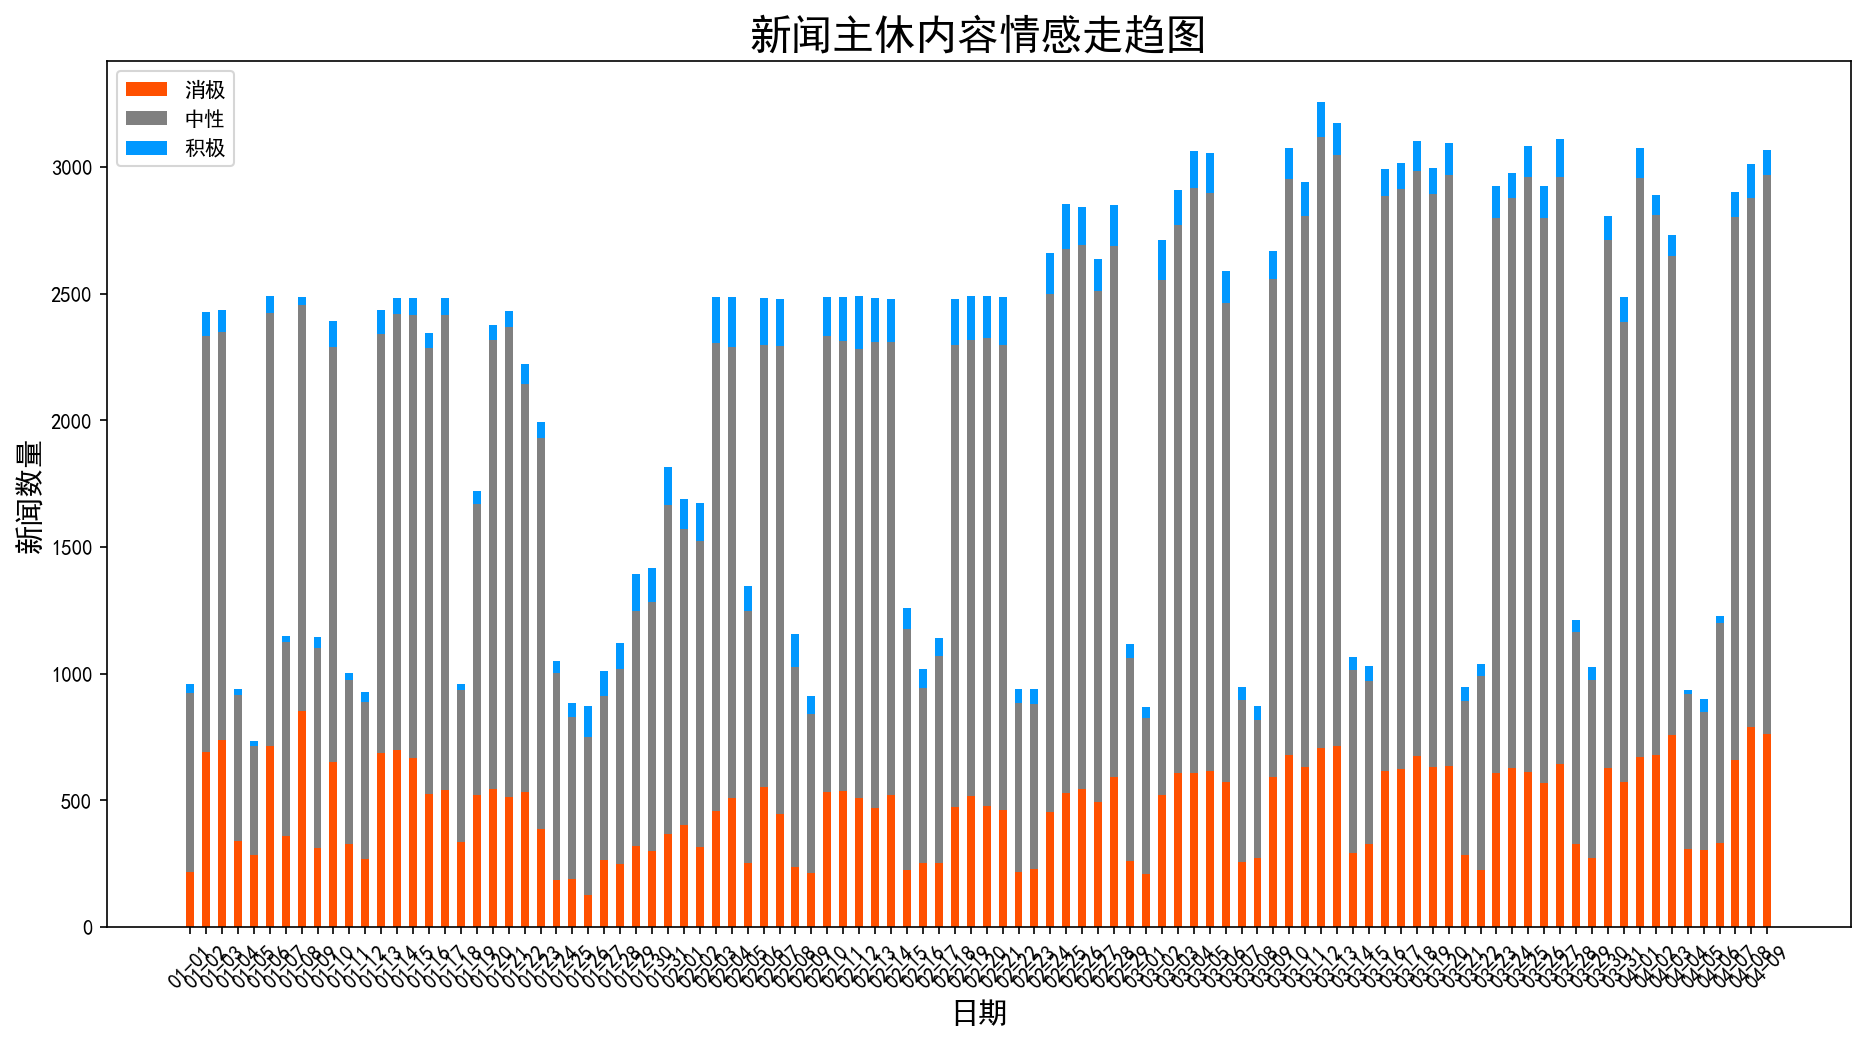

In [28]:
a,b,c = news_emotion_day['label_2'].values, news_emotion_day['label_1'].values, news_emotion_day['label_0'].values
x=range(len(news_emotion_day))
x_tick_label = news_emotion_day['time'].map(lambda t: t.replace('2020-','')).values
plt.figure(figsize=(15, 7.5), dpi=150)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.bar(x, a, width=0.5, color='#ff5000', label='消极')
plt.bar(x, b, bottom=a, width=0.5, color='gray', label='中性')
plt.bar(x, c, bottom=a+b, width=0.5, color='#0198ff', label='积极')

plt.title("新闻主休内容情感走趋图", loc="center",size=20)
plt.xlabel("日期", size=14)
plt.xticks(x,labels = x_tick_label, rotation = 45)
plt.ylabel("新闻数量", size=14)
plt.legend()
plt.show()

#### 6.3.8、新闻主休内容情感的时段分布

In [33]:
news_emotion_hour = news_emotion_merge.groupby('hour')['label_0','label_1','label_2'].sum().reset_index()
news_emotion_hour

/tmp/ipykernel_33484/2421617158.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  news_emotion_hour = news_emotion_merge.groupby('hour')['label_0','label_1','label_2'].sum().reset_index()


,hour,label_0,label_1,label_2
0,0,263,3955,1199
1,1,129,2535,725
2,2,135,2408,902
3,3,134,1830,620
4,4,501,2690,679
5,5,281,2787,692
6,6,308,3594,789
7,7,364,6900,2186
8,8,376,7696,2472
9,9,643,9518,2911


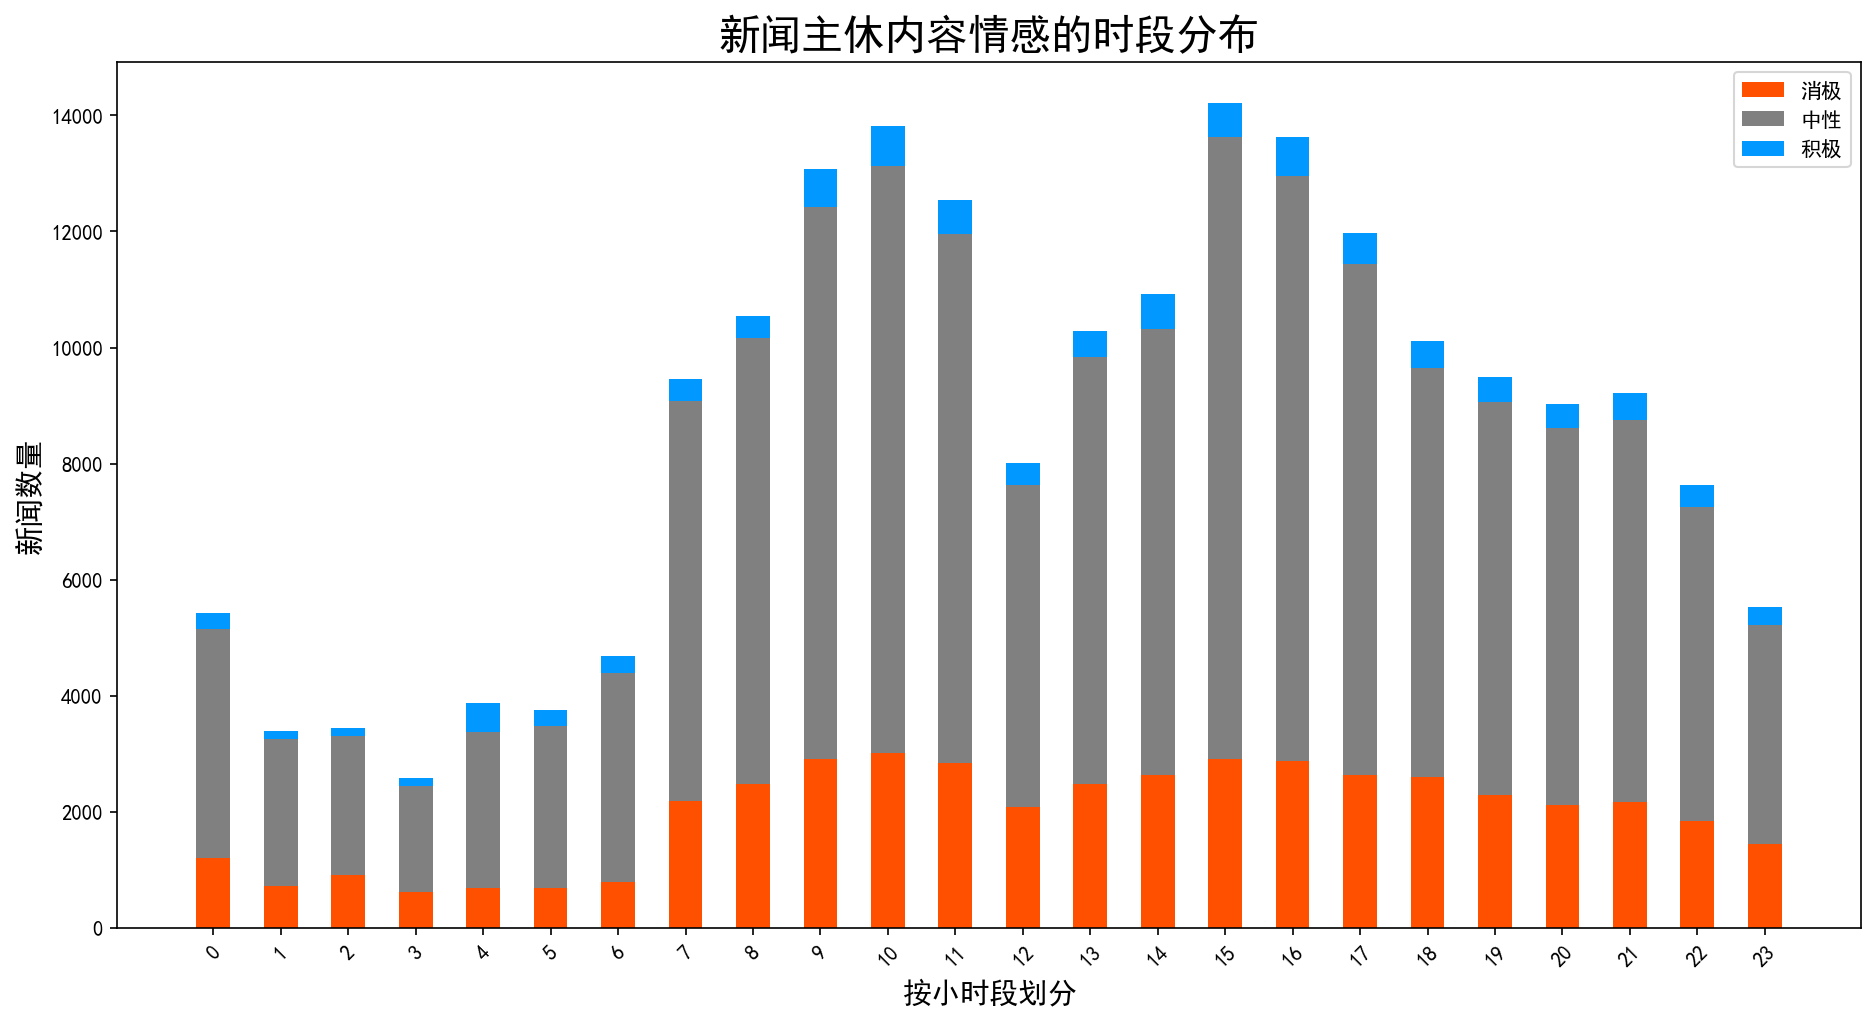

In [37]:
# news_emotion_hour = news_emotion_merge.groupby('hour')['label_0','label_1','label_2'].sum().reset_index()

a,b,c = news_emotion_hour['label_2'].values, news_emotion_hour['label_1'].values, news_emotion_hour['label_0'].values
x=range(len(news_emotion_hour))
x_tick_label = news_emotion_hour['hour'].values
plt.figure(figsize=(15, 7.5), dpi=150)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.bar(x, a, width=0.5, color='#ff5000', label='消极')
plt.bar(x, b, bottom=a, width=0.5, color='gray', label='中性')
plt.bar(x, c, bottom=a+b, width=0.5, color='#0198ff', label='积极')
plt.title("新闻主休内容情感的时段分布", loc="center",size=20)
plt.xlabel("按小时段划分", size=14)
plt.xticks(x,labels = x_tick_label, rotation = 45)
plt.ylabel("新闻数量", size=14)
plt.legend()
plt.show()

#### 2.3.9、预警：新闻评论情感与主休内容情感差异Top10

按某新闻计算所有评论的平均情感得分

In [115]:
def get_comments_emotion_label(x):
    fm = (x.label_0 + x.label_1 + x.label_2)
    if fm == 0 :
        return 0
    val = (x.label_0 - x.label_2)/fm
    return val
def get_news_emotion_label(x):
    if x.label_0 >= 0.5 :
        return 1
    elif x.label_1 >= 0.5 :
        return 0
    else:
        return -1

In [126]:
comments_emotion_2_news = comments_emotion_fin.copy()
comments_emotion_2_news = comments_emotion_2_news.groupby('url')['label_0','label_1','label_2'].sum().reset_index()
comments_emotion_2_news['comments_label'] = comments_emotion_2_news.apply(get_comments_emotion_label,axis=1)
comments_emotion_2_news = comments_emotion_2_news.drop(columns=['label_0','label_1','label_2'])
comments_emotion_2_news

/tmp/ipykernel_33484/1496955874.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  comments_emotion_2_news = comments_emotion_2_news.groupby('url')['label_0','label_1','label_2'].sum().reset_index()


,url,comments_label
0,http://tech.sina.com.cn/csj/2020-01-01/doc-iih...,-0.333333
1,http://tech.sina.com.cn/csj/2020-01-01/doc-iih...,0.000000
2,http://tech.sina.com.cn/csj/2020-01-01/doc-iih...,0.000000
3,http://tech.sina.com.cn/csj/2020-01-02/doc-iih...,0.000000
4,http://tech.sina.com.cn/csj/2020-01-02/doc-iih...,-1.000000
...,...,...
29316,https://tech.sina.com.cn/t/2020-03-07/doc-iimx...,0.000000
29317,https://tech.sina.com.cn/t/2020-03-07/doc-iimx...,0.000000
29318,https://tech.sina.com.cn/t/2020-03-07/doc-iimx...,0.000000
29319,https://tech.sina.com.cn/t/2020-03-08/doc-iimx...,-1.000000


计算新闻的情感得分

In [165]:
news_emotion_label = news_emotion_merge.copy()
news_emotion_label['news_label'] = news_emotion_label.apply(get_news_emotion_label,axis=1)
news_emotion_label = news_emotion_label.drop(columns=['id', 'hour', 'label_0','label_1','label_2'])
news_emotion_label

,url,time,news_label
0,https://finance.sina.com.cn/stock/hyyj/2020-03...,2020-03-05,0
1,https://finance.sina.com.cn/stock/quanshang/qs...,2020-03-05,-1
2,https://finance.sina.com.cn/stock/stockzmt/202...,2020-03-05,0
3,https://finance.sina.com.cn/stock/zqgd/2020-03...,2020-03-05,0
4,https://finance.sina.com.cn/stock/zqgd/2020-03...,2020-03-05,0
...,...,...,...
207077,https://tech.sina.com.cn/roll/2020-03-16/doc-i...,2020-03-16,0
207078,https://tech.sina.com.cn/roll/2020-03-16/doc-i...,2020-03-16,-1
207079,https://tech.sina.com.cn/roll/2020-03-16/doc-i...,2020-03-16,-1
207080,https://tech.sina.com.cn/roll/2020-03-16/doc-i...,2020-03-16,0


找出评论的情感与主体内容差异最大的Top10 新闻

In [171]:
emotion_contrast = pd.merge(comments_emotion_2_news, news_emotion_label, on ='url', how = 'left')
emotion_contrast

,url,comments_label,time,news_label
0,http://tech.sina.com.cn/csj/2020-01-01/doc-iih...,-0.333333,2020-01-01,0.0
1,http://tech.sina.com.cn/csj/2020-01-01/doc-iih...,0.000000,2020-01-01,0.0
2,http://tech.sina.com.cn/csj/2020-01-01/doc-iih...,0.000000,2020-01-01,0.0
3,http://tech.sina.com.cn/csj/2020-01-02/doc-iih...,0.000000,2020-01-02,0.0
4,http://tech.sina.com.cn/csj/2020-01-02/doc-iih...,-1.000000,2020-01-02,-1.0
...,...,...,...,...
29316,https://tech.sina.com.cn/t/2020-03-07/doc-iimx...,0.000000,2020-03-07,0.0
29317,https://tech.sina.com.cn/t/2020-03-07/doc-iimx...,0.000000,2020-03-07,0.0
29318,https://tech.sina.com.cn/t/2020-03-07/doc-iimx...,0.000000,NaN,NaN
29319,https://tech.sina.com.cn/t/2020-03-08/doc-iimx...,-1.000000,2020-03-08,-1.0


In [172]:
emotion_contrast['contrast'] = np.abs( emotion_contrast['news_label'] - emotion_contrast['comments_label'])
emotion_contrast = emotion_contrast.fillna(0)
emotion_contrast = emotion_contrast.groupby('time')['url', 'contrast'].apply(lambda c: c.sort_values('contrast', ascending= False).head(10)).reset_index()
emotion_contrast

/tmp/ipykernel_33484/609600346.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  emotion_contrast = emotion_contrast.groupby('time')['url', 'contrast'].apply(lambda c: c.sort_values('contrast', ascending= False).head(10)).reset_index()


,time,level_1,url,contrast
0,0,1749,https://finance.sina.com.cn/chanjing/gsnews/20...,0.0
1,0,28286,https://tech.sina.com.cn/mobile/n/n/2020-01-23...,0.0
2,0,28281,https://tech.sina.com.cn/mobile/n/n/2020-01-22...,0.0
3,0,28277,https://tech.sina.com.cn/mobile/n/n/2020-01-21...,0.0
4,0,28272,https://tech.sina.com.cn/mobile/n/n/2020-01-20...,0.0
...,...,...,...,...
686,2020-03-08,10308,https://finance.sina.com.cn/stock/usstock/c/20...,1.0
687,2020-03-08,12659,https://mil.news.sina.com.cn/jssd/2020-03-08/d...,1.0
688,2020-03-08,19155,https://news.sina.com.cn/c/2020-03-08/doc-iimx...,1.0
689,2020-03-08,19134,https://news.sina.com.cn/c/2020-03-08/doc-iimx...,1.0


In [177]:
pd.merge(news_data, emotion_contrast['url'], on='url', how='inner')

,time,title,url,hour,content,description,keyword,type,id,label
0,2020-03-05,一名乡村青年志愿者倒在战“疫”路上,https://news.sina.com.cn/o/2020-03-05/doc-iimx...,2,原标题：一名乡村青年志愿者倒在战“疫”路上 31岁的贾庆臣在微信朋友圈更新的最后动态，是一段...,村青年志愿者倒在战“疫”路上,志愿者 新冠肺炎,news,453d015e-b8cc-4831-a7b5-74e55a52ae06,0
1,2020-03-05,从健身房到客厅 疫情过后“云健身”能否常态化？,https://tech.sina.com.cn/i/2020-03-05/doc-iimx...,4,从健身房到客厅 疫情过后“云健身”能否常态化？ 作者： 邱智丽 传统线下行业会面临新一轮的整...,从健身房到客厅 疫情过后“云健身”能否常态化？,疫情 云健身 新冠肺炎,news,c329bad8-5b05-4e04-8b1e-e18f2c3f520a,0
2,2020-03-05,利差走阔平添中国资产亮色 股债汇稳健运行,https://finance.sina.com.cn/roll/2020-03-05/do...,5,高层定调新基建，七大板块迎风口！来新浪理财大学，听开年重磅专栏“交易日财经早报”。 4日央行...,利差走阔平添中国资产亮色 股债汇稳健运行,降息 美联储,news,be226b1d-3a93-453f-b77f-0c27b701ea07,0
3,2020-03-05,华春莹这条推特下 日本网友纷纷飙起蹩脚中文感谢,https://mil.news.sina.com.cn/china/2020-03-05/...,7,原标题：华春莹发了条日语推特，日本网友纷纷飙中文感谢 [文/观察者网 陆雨聆]“救患若一，所...,原标题：华春莹发了条日语推特，日本网友纷纷飙中文感谢[文/观察者网陆雨聆]“救患若一，所忧同...,华春莹 日本 中国 新冠肺炎,none,da2d4693-9d16-49cc-a282-559b557d5c09,0
4,2020-03-05,最新通报：美国确诊158例新冠肺炎病例,https://news.sina.com.cn/w/2020-03-05/doc-iimx...,9,原标题：快讯！最新通报：美国确诊158例新冠肺炎病例 [环球网快讯]美国有线电视新闻网（CN...,最新通报：美国确诊158例新冠肺炎病例[环球网快讯]美国有线电视新闻网（CNN）援引美国疾控...,新冠肺炎 美国,news,c9084210-dec6-4241-8483-ffcd9f2222e1,0
...,...,...,...,...,...,...,...,...,...,...
676,2020-01-05,伊“圣城”清真寺首挂象征“复仇”红旗 或大战在即,https://mil.news.sina.com.cn/world/2020-01-05/...,18,[环球网报道 记者 朱梦颖]伊朗名将、伊斯兰革命卫队负责海外行动的指挥官苏莱马尼将军3日遭美...,NaN,伊朗,none,e2be78b7-3b32-406c-9533-37c482670957,0
677,2020-01-05,环卫工给发病男子当靠垫：只要不怕脏 我给你垫背,https://news.sina.com.cn/o/2020-01-05/doc-iihn...,18,原标题：环卫大姐给发病男子当靠垫：只要不怕我脏，我给你垫背 近日，四川广元，一男子突发疾病倒...,姐给发病男子当靠垫：只要不怕我脏，我给你垫背近日，四川广元，一男子突发疾病倒地，64岁环卫大...,环卫,news,0c8a059a-c951-4eaf-b339-5eaab43ed765,0
678,2020-01-05,波音一蹶不振，把全球第一“让”给了死对头,https://finance.sina.com.cn/stock/usstock/c/20...,21,原标题：波音一蹶不振，把全球第一“让”给了死对头 来源：每日经济新闻 每经编辑 李净翰 ...,波音一蹶不振，把全球第一“让”给了死对头,NaN,news,3d2a98e4-38bc-49b2-ae9c-374aa76f3ff3,0
679,2020-01-05,美伊关系紧张海湾地区股市暴跌 沙特阿美创历史新低,https://finance.sina.com.cn/stock/usstock/c/20...,22,新浪美股 北京时间1月5日讯，科威特和沙特股市领跌海湾地区股市，周日尾盘大幅走低，此前美国在...,美伊关系紧张海湾地区股市暴跌 沙特阿美创历史新低,NaN,news,8946a3c3-c1b3-487a-9fff-5ae488103103,0
